### Задание 0.

Посчитайте 2 шага градиентного спуска для примера, который мы разбирали на занятии, с учетом свободного коэффициента (то есть, надо посчитать не только градиенты по $w_1$, но и по $w_0$.

Будем считать, что наша выборка состоит из следующих объектов:

 № | x | $y_{true}$ |
| --- | --- | --- |
| 1 | 3 | 7 |
| 2 | 5 | 11 |

Веса инициализируем как $w_1 = 1$ и $w_0 = 0$. Возьмем $\eta = 0.01$.

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
d = {'x': [3, 5], 'y_t': [7, 11]}
data = pd.DataFrame(data=d)

w1 = 1
w0 = 0
eta = 0.01 # learning rate

for i in range(2): # делаем 2 шага
  # градиент для w0
  gradient_w0 = -2 * (data['y_t'][0] - (w1 * data['x'][0] + w0)) + -2 * (data['y_t'][1] - (w1 * data['x'][1] + w0))
  gradient_w0 /= len(data['x'])

  # градиент для w1
  gradient_w1 = -2 * (data['y_t'][0] - (w1 * data['x'][0] + w0)) * data['x'][0] + -2 * (data['y_t'][1] - (w1 * data['x'][1] + w0)) * data['x'][1]
  gradient_w1 /= len(data['x'])

  # на каждом шаге обновляем веса, умножая на коэффициент learning rate
  w0 = w0 - eta * gradient_w0
  w1 = w1 - eta * gradient_w1

  print(f'Веса на шаге {i + 1}: w0 = {w0}, w1 = {w1}')

Веса на шаге 1: w0 = 0.1, w1 = 1.42
Веса на шаге 2: w0 = 0.16440000000000002, w1 = 1.6892


# Задание 1.

Поработайте с датасетом про цены мобильных телефонов, обучите регрессию.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/yodiiin/mag2023/main/CL/term02/02-Regularization%2C%20Normalization/Cellphone.csv')
data.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


### Предобработка датасета

In [ ]:
data.dtypes

Product_id        int64
Price             int64
Sale              int64
weight          float64
resoloution     float64
ppi               int64
cpu core          int64
cpu freq        float64
internal mem    float64
ram             float64
RearCam         float64
Front_Cam       float64
battery           int64
thickness       float64
dtype: object

In [ ]:
data.isna().sum() # пропущенных значений нет

Product_id      0
Price           0
Sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
RearCam         0
Front_Cam       0
battery         0
thickness       0
dtype: int64

In [ ]:
data.shape

(161, 13)

In [ ]:
data.drop(['Product_id'], axis=1, inplace=True)
data.head()

,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


### Исследование данных

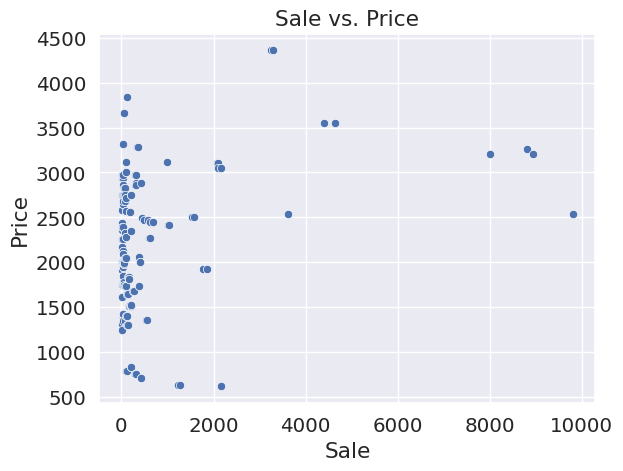

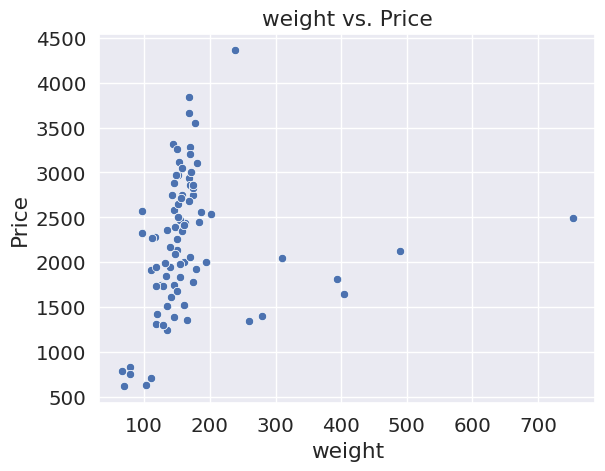

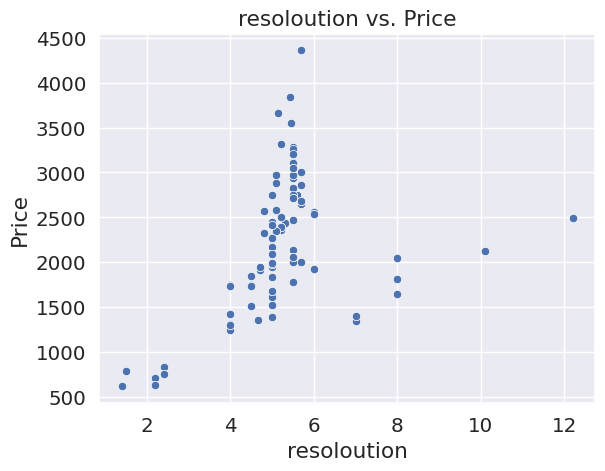

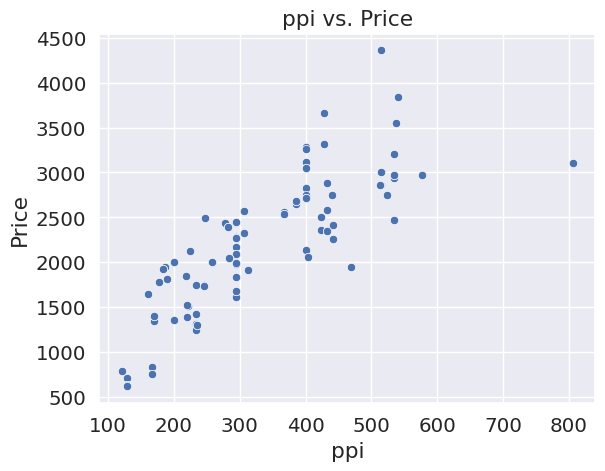

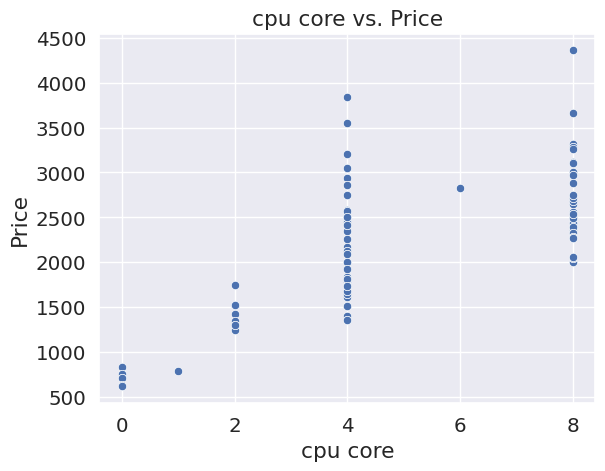

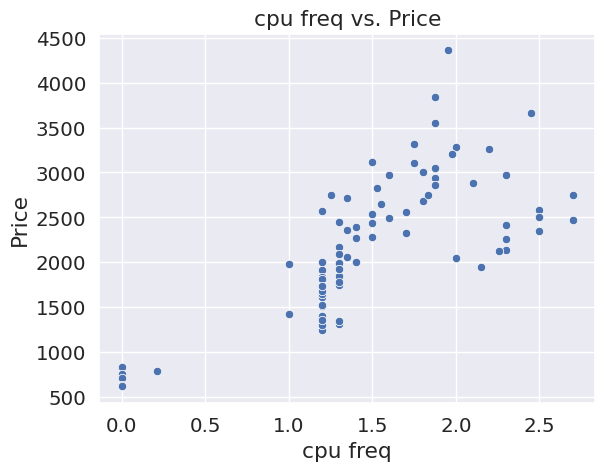

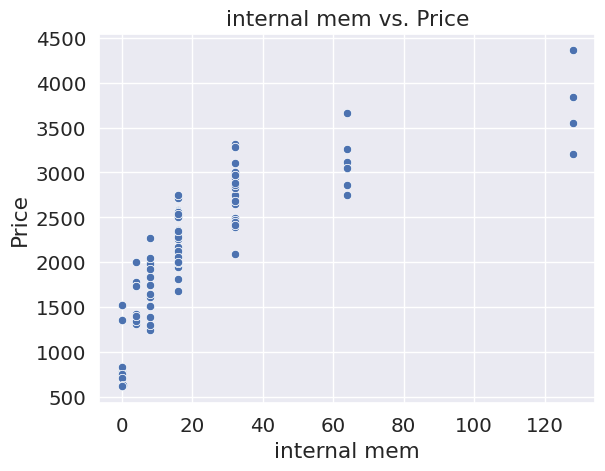

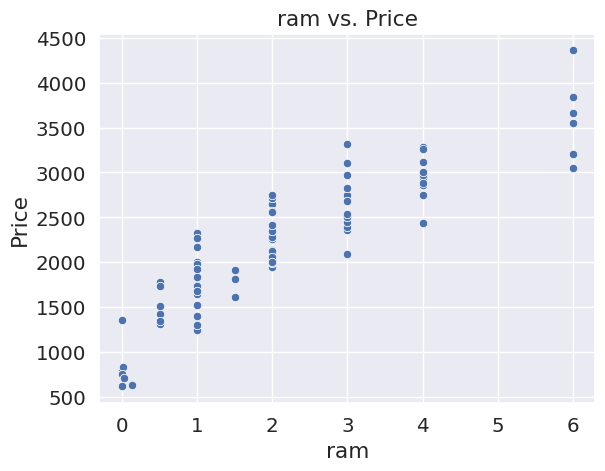

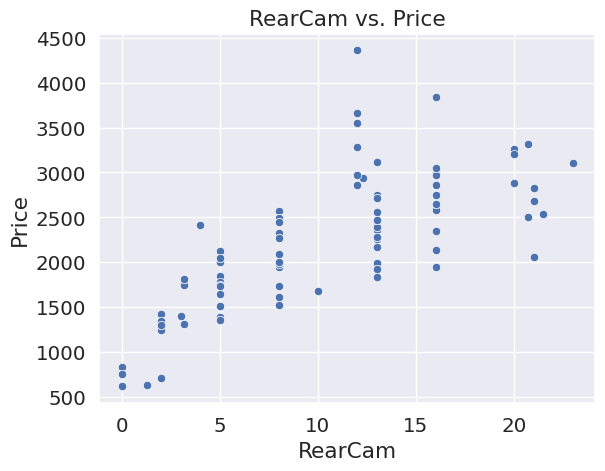

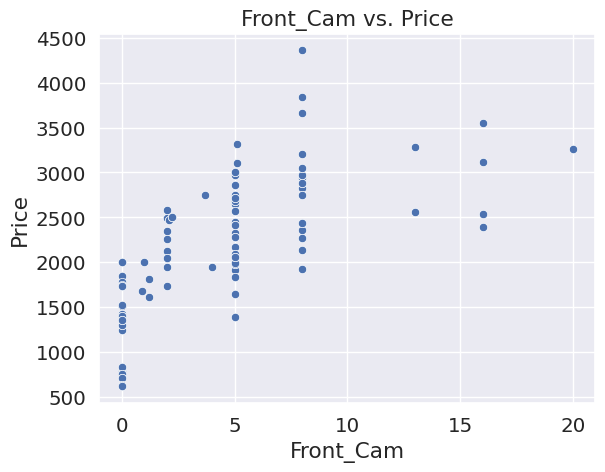

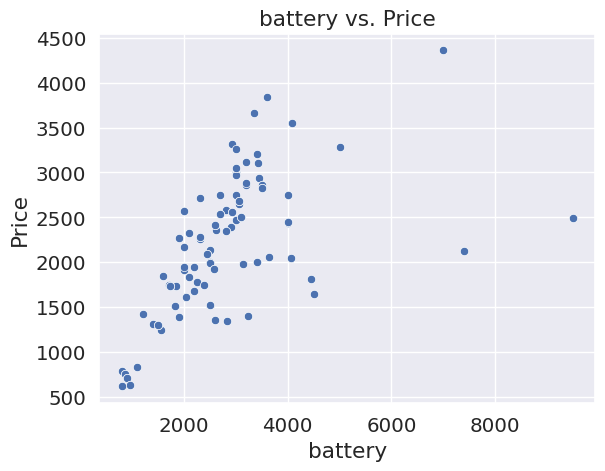

In [ ]:
features = data.drop(['Price'], axis=1)

for feature in features:
    sns.scatterplot(x=feature, y='Price', data=data)
    plt.title(f'{feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    print()
    plt.show()

<Axes: >

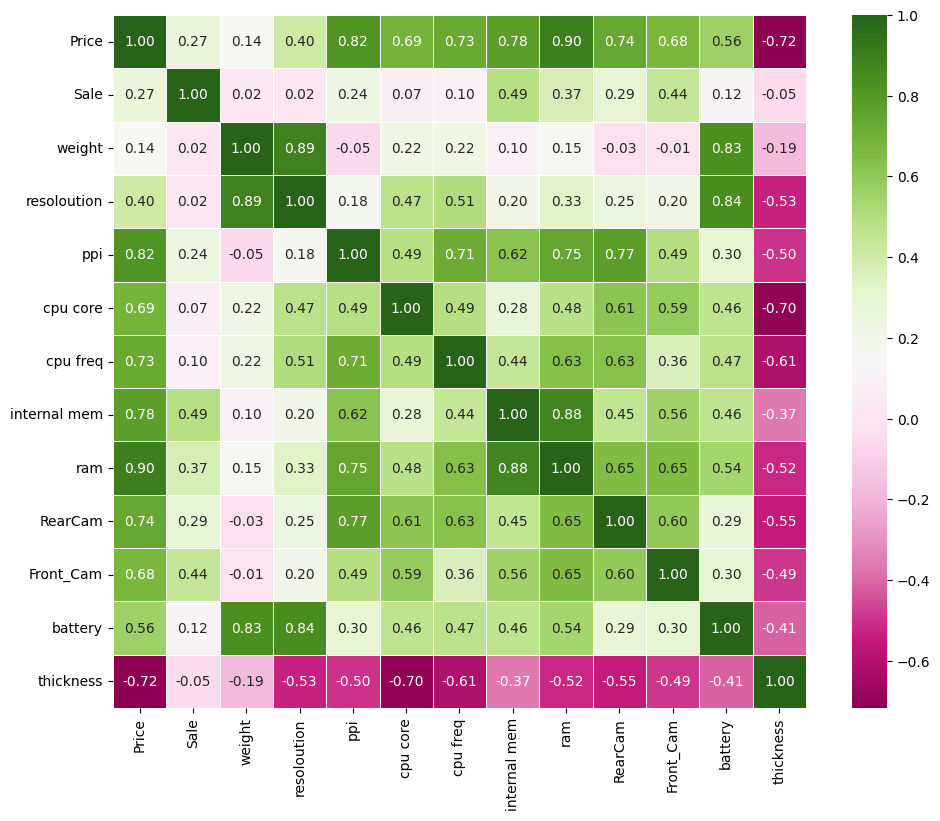

In [ ]:
# посмотрим на хитмэпе, какие признаки коррелируют с ценой
plt.figure(figsize=(12, 9))

corr = data.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', \
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.color_palette("PiYG", as_cmap=True), square=True)

У thickness со всеми признаками отрциательная корреляция, думаю, можно дропнуть. Сначала обучу регрессию с этим признаком, потому удалю его, обучу снова и посмотрю на результат

### Линейная регрессия

In [ ]:
# обучаем линейную регрессию
X = data.copy().drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
model = LinearRegression()
model.fit(X_train, y_train) # обучение модели
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [ ]:
print(f'MSE на тесте: {mean_squared_error(pred_test, y_test) ** 0.5}\nMSE на обучении: {mean_squared_error(pred_train, y_train) ** 0.5}')

MSE на тесте: 213.4663623764059
MSE на обучении: 157.57572927605557


In [ ]:
# коэффициент детерминации
r2_score(y_train, pred_train), r2_score(y_test, pred_test)
# 0.9522617933579549, 0.9442404197899782

(0.9522617933579549, 0.9442404197899773)

мы точно не переобучились...

In [ ]:
# посмотрим на коэффициенты
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1)
coefficients

,0,0
0,Sale,0.004214
1,weight,-0.958193
2,resoloution,-49.224525
3,ppi,1.427725
4,cpu core,47.941797
5,cpu freq,101.038390
6,internal mem,4.776109
7,ram,74.728949
8,RearCam,-0.058522
9,Front_Cam,7.544211


Дропаем thickness и смотрим, что будет...

In [ ]:
data.drop(['thickness'], axis=1, inplace=True)

In [ ]:
X = data.copy().drop('Price', axis=1)
y = data['Price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=111)
model = LinearRegression()
model.fit(X_train1, y_train1) # обучение модели
pred_train1 = model.predict(X_train1)
pred_test1 = model.predict(X_test1)

In [ ]:
print(f'MSE на тесте: {mean_squared_error(pred_test1, y_test1) ** 0.5}\nMSE на обучении: {mean_squared_error(pred_train1, y_train1) ** 0.5}')

MSE на тесте: 217.72599076339512
MSE на обучении: 179.03726874668695


In [ ]:
# коэффициент детерминации
r2_score(y_train1, pred_train1), r2_score(y_test1, pred_test1)

(0.9383725303509102, 0.9419929008536201)

Как будто переобучились даже, и качество стало похуже... Возвращаем обратно

### Пробуем масштабировать и добавлять регуляризацию

In [ ]:
X = data.copy().drop('Price', axis=1)
y = data['Price']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression() # бейзлайн
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)
print(ypred_test)

[3319.60807542 2667.10550207 3515.18109087 3046.78184591 2812.58265143
 2538.11985426 3515.21480432 1558.918869    804.0850931  3489.33572383
 3280.92090214 2699.23441256 2219.09495317  920.13852427 1744.23568417
 2264.99129316 2764.81616241 2052.05878676 2720.34495893 2666.81893776
 2275.13631498 1874.78165555 3129.19754542 2633.76968504  621.15048938
 1881.67518978 2030.80047033 2955.57574104 3280.89140287 2482.13095016
  930.57340661 1546.22183452 1466.51819934]


In [ ]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test)

(0.9522617933579549, 0.9442404197899782)

После масштабирования вообще ничего не поменялось....

#### L1-регуляризация

In [ ]:
regressor2 = Lasso(alpha=10)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('Scores:', r2_score(ytest, ypred2), mean_squared_error(ytest, ypred2))
print(regressor2.coef_,'\n') # качество стало хуже

Scores: 0.9429123312264887 46653.229443563796
[   0.          -42.60899724   -0.          187.82466294  122.24523073
   40.40255799  150.785366    144.59053409    0.86715073   22.20412683
   87.84848882 -138.04115936] 



In [ ]:
for a in np.arange(0.1, 100.1, 25):
    regressor2 = Lasso(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest, ypred2))
    print(regressor2.coef_,'\n')

alpha=0.1
Scores: 0.9443176927059537 45504.73883322292
[   6.35693317  -96.01636463  -74.39075799  180.12940827  113.77520522
   56.56144134  126.68198356  113.23364804    0.           33.27119845
  219.71278267 -163.28571027] 

alpha=25.1
Scores: 0.9390704098113625 49792.92747528989
[   0.           -0.           -0.          182.49932055  125.74035538
   36.53870604  146.71738137  172.576701      0.           11.54887881
   30.36568926 -132.33152404] 

alpha=50.1
Scores: 0.9324128465946934 55233.626508115194
[   0.            0.            0.          167.02181331  121.35439488
   30.4897244   124.42350664  205.18650368    0.            0.
   12.98306977 -124.6837738 ] 

alpha=75.1
Scores: 0.9216253727974423 64049.37430430304
[   0.            0.            0.          154.26089674  111.22012808
   24.590247     99.31360253  231.51398313    0.            0.
    0.         -116.57342811] 



In [ ]:
# подбираем альфу по кросс-валидации
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

lasso_cv = LassoCV(alphas=alphas,
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        8.30854271,  8.35829146,  8.4080402 ,  8.45778894,  8.50753769,
        8.55728643,  8.60703518,  8.65678392,  8.70653266,  8.75628141,
        8.80603015,  8.85577889,  8.90552764,  8.95527638,  9.00502513,
        9.05477387,  9.10452261,  9.15427136,  9.2040201 ,  9.25376884,
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        cv=4, random_state=17)

In [ ]:
lasso_cv.alpha_

10.0

In [ ]:
# суем эту альфу
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred2_train), r2_score(ytest, ypred2_test))

Scores: 0.9478429932336722 0.9429123312264887


Стало чуть лучше, но качество после применения Lasso в целом стало хуже по сравнению с линейной регрессией без регуляризации.

#### L2-регуляризация

In [ ]:
from sklearn.linear_model import Ridge

for a in np.arange(0.1, 20.1, 2):
    regressor3 = Ridge(alpha=a)
    regressor3.fit(Xtrain, ytrain)

    ypred3 = regressor3.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest, ypred3), mean_squared_error(ytest, ypred3))
    print(regressor3.coef_)

alpha=0.1
Scores: 0.9444293287061398 45413.50757360525
[ 6.30164327e+00 -9.45007543e+01 -7.55068511e+01  1.79667489e+02
  1.13979640e+02  5.70942412e+01  1.26872482e+02  1.13434173e+02
  1.09978116e-01  3.34032601e+01  2.18825742e+02 -1.63353430e+02]
alpha=2.1
Scores: 0.9467268544285271 43535.921801023156
[   1.84145693  -74.81656757  -67.53332519  172.01206354  115.82982618
   60.06473573  136.61872853  118.86784371    7.33341883   33.88102402
  186.24159047 -156.46887443]
alpha=4.1
Scores: 0.9476145696343017 42810.46248440873
[  -0.5764357   -64.93268177  -58.61981133  166.67342944  116.02636589
   61.72630052  141.64381974  122.69310269   12.54689144   34.69835881
  165.3089837  -150.68443289]
alpha=6.1
Scores: 0.9478873270967512 42587.559417047836
[  -1.99594123  -58.5275919   -51.12266666  162.51163733  115.47928052
   62.97815966  144.36557053  125.39638217   16.77148519   35.73594808
  150.4198214  -145.98641225]
alpha=8.1
Scores: 0.9478276879089105 42636.29780090431
[  -2.82549

In [ ]:
# подбираем альфу по кросс-валидации
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,
                   scoring='r2',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='r2')

In [ ]:
ridge_cv.alpha_

23.81685551976158

In [ ]:
# вставляем альфу
regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test))

Scores: 0.9428760728552831 0.9393076973570419


Ridge получился хуже, чем Lasso

#### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

regressor3 = ElasticNet(alpha=0.1, l1_ratio=0.5)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test))

Scores: 0.9508434406089189 0.9478465370130211


ElasticNet лучше Lasso и лучше Ridge, но без регуляизации как будто было лучше всего

In [ ]:
# смотрим кросс-валидацию
from sklearn.model_selection import cross_val_score

print(cross_val_score(regressor3, X, y, cv=3, scoring='r2'))
print(cross_val_score(regressor3, X, y, cv=3, scoring='r2').mean())

[0.83581786 0.94840737 0.92160375]
0.9019429938732536


# Задание 2.

Поработайте с датасетом diet_data (Его создатель решил похудеть, подсчитывая калории, и ему это действительно удалось; в течение времени, пока худел, он записывал, что и какое он ест). Целевая колонка - change.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/yodiiin/mag2023/main/CL/term02/02-Regularization%2C%20Normalization/diet_data.csv')
data.head(10)

,Date,Stone,Pounds,Ounces,weight_oz,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,change
0,7/30/2018,12.0,2.0,6.0,2726.0,1950.0,0.72,1.0,1.0,0.0,0.0,0.0,0.0,-30.0
1,7/31/2018,12.0,0.0,8.0,2696.0,2600.0,0.96,1.0,0.0,0.0,0.0,0.0,0.0,8.0
2,8/1/2018,12.0,1.0,0.0,2704.0,2500.0,0.92,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8/2/2018,12.0,1.0,0.0,2704.0,1850.0,0.68,1.0,1.0,0.0,1.0,0.0,0.0,-40.0
4,8/3/2018,11.0,12.0,8.0,2664.0,2900.0,1.09,1.0,1.0,0.0,0.0,0.0,0.0,14.0
5,8/4/2018,11.0,13.0,6.0,2678.0,3600.0,1.34,0.0,0.0,0.0,0.0,0.0,0.0,14.0
6,8/5/2018,12.0,0.0,4.0,2692.0,2400.0,0.89,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
7,8/6/2018,12.0,0.0,2.0,2690.0,3100.0,1.15,1.0,1.0,0.0,0.0,0.0,0.0,6.0
8,8/7/2018,12.0,0.0,8.0,2696.0,2200.0,0.82,1.0,1.0,0.0,0.0,0.0,0.0,-8.0
9,8/8/2018,12.0,0.0,0.0,2688.0,1800.0,0.67,1.0,1.0,0.0,0.0,0.0,0.0,-40.0


In [ ]:
data.shape

(151, 14)

In [ ]:
data.dtypes

Date            object
Stone          float64
Pounds         float64
Ounces         float64
weight_oz      float64
calories       float64
cals_per_oz     object
five_donuts    float64
walk           float64
run            float64
wine           float64
prot           float64
weight         float64
change         float64
dtype: object

Дропаем столбцы:
- Date не нужна (одинь день = одна строка)
- отдельно Stone, Pounds & Ounces тоже не нужны, т.к. вес записан в унциях в weight_oz
- cals_per_oz тоже не нужен, т.к. это просто соотношение calories/weight_oz

In [ ]:
data.drop(['Date', 'Stone', 'Pounds', 'Ounces', 'cals_per_oz'], axis=1, inplace=True)

In [ ]:
data[data.isnull().any(1)]

<ipython-input-47-dd0f9a2b542d>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  data[data.isnull().any(1)]


,weight_oz,calories,five_donuts,walk,run,wine,prot,weight,change
60,2672.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,2598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2598.0
144,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
145,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
146,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
147,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
148,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
149,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# в строках с NaN почти нет больше никаких данных, поэтому я решила их дропнуть
data = data.dropna()
data.shape

(140, 9)

In [ ]:
data.dtypes

weight_oz      float64
calories       float64
five_donuts    float64
walk           float64
run            float64
wine           float64
prot           float64
weight         float64
change         float64
dtype: object

In [ ]:
data.head()

,weight_oz,calories,five_donuts,walk,run,wine,prot,weight,change
0,2726.0,1950.0,1.0,1.0,0.0,0.0,0.0,0.0,-30.0
1,2696.0,2600.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0
2,2704.0,2500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2704.0,1850.0,1.0,1.0,0.0,1.0,0.0,0.0,-40.0
4,2664.0,2900.0,1.0,1.0,0.0,0.0,0.0,0.0,14.0


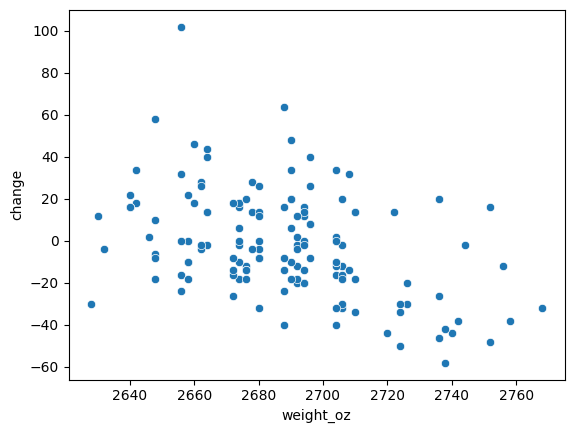

In [ ]:
sns.scatterplot(x='weight_oz', y='change', data=data)
plt.xlabel('weight_oz')
plt.ylabel('change')
plt.show()

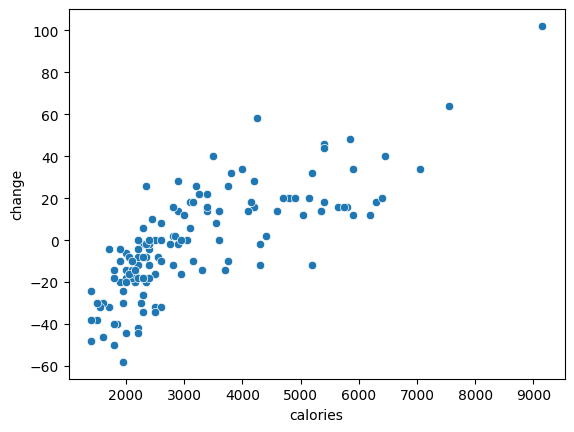

In [ ]:
sns.scatterplot(x='calories', y='change', data=data)
plt.xlabel('calories')
plt.ylabel('change')
plt.show()

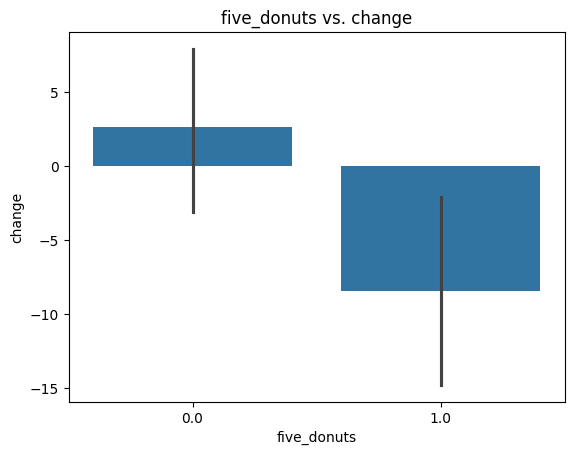

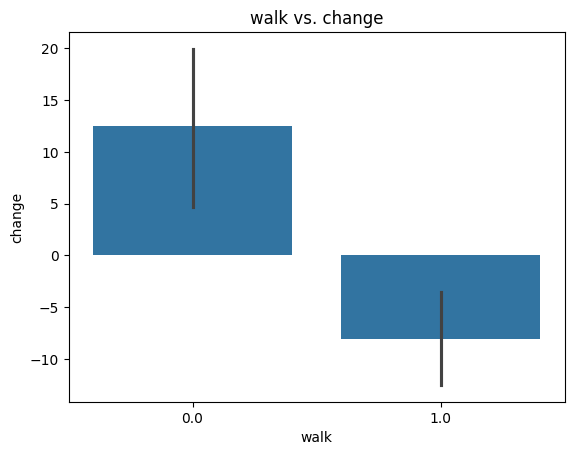

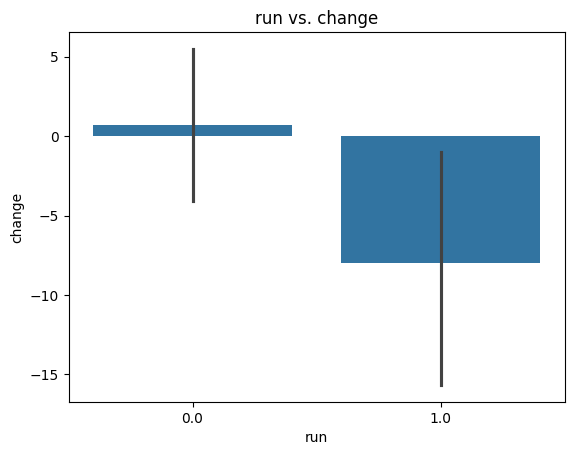

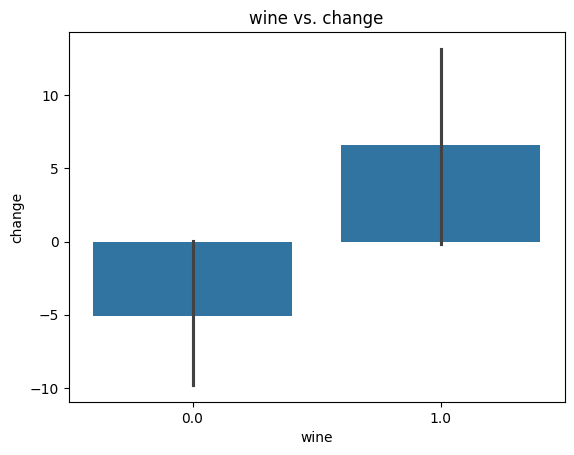

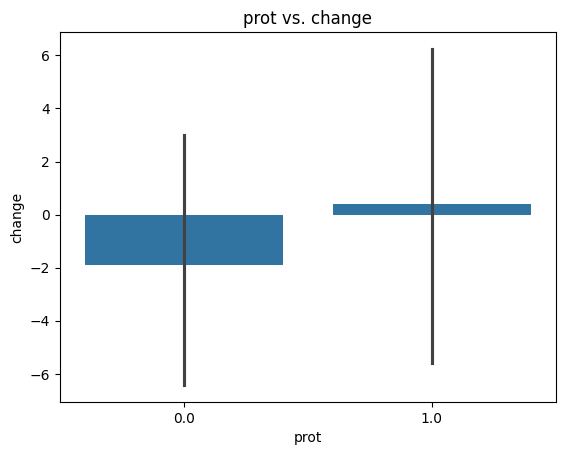

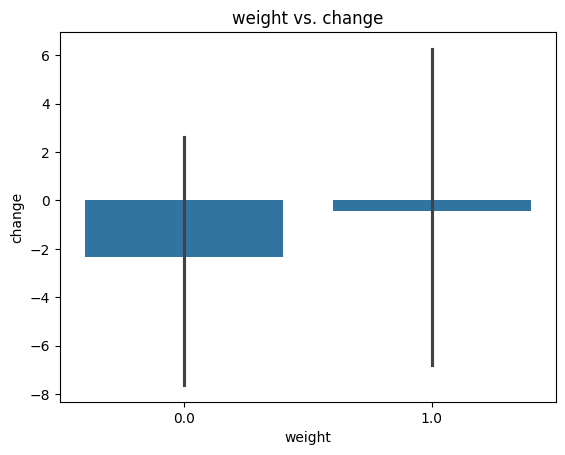

In [ ]:
features = ['five_donuts', 'walk', 'run', 'wine', 'prot', 'weight']

for feature in features:
    sns.barplot(x=feature, y='change', data=data)
    plt.title(f'{feature} vs. change')
    print()
    plt.show()

<Axes: >

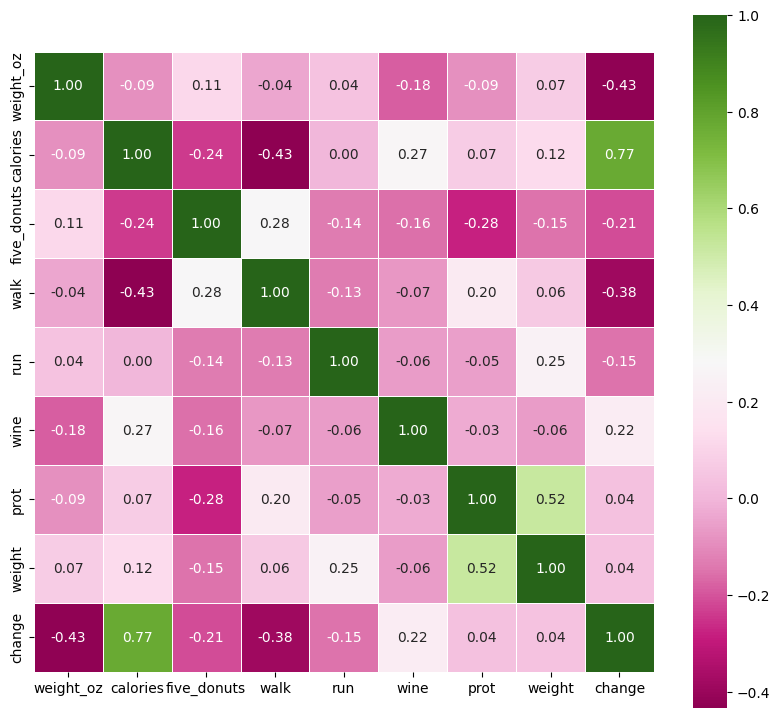

In [ ]:
plt.figure(figsize=(10, 9))

corr = data.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', \
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.color_palette("PiYG", as_cmap=True), square=True)

#### Линейная регрессия

In [ ]:
X = data.copy().drop('change', axis=1)
y = data['change']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

model = LinearRegression()
model.fit(Xtrain, ytrain)

ypred_train = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
print(ypred_test)

[-16.20039569 -30.77755825 -31.83994473  -8.67503245  -0.33172731
  56.40208675   7.76256637   0.63783057 -26.17063834 -17.93482223
  15.19182282 -27.44343463   5.76577748  -6.54116226  20.95943166
 -18.43805271  -4.71564622   3.10713501  17.23568238  -5.96062616
 -13.13991587  -7.25061094  36.86706657   9.75961271 -21.04438967
  -1.46725876 -10.6594654    7.12124147]


In [ ]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1)
coefficients

,0,0
0,weight_oz,-0.356052
1,calories,0.011764
2,five_donuts,-2.325341
3,walk,-6.195293
4,run,-11.510125
5,wine,-4.812772
6,prot,-9.159701
7,weight,3.927990


In [ ]:
print(f'MSE test: {mean_squared_error(ypred_test, ytest) ** 0.5}\nMSE train: {mean_squared_error(ypred_train, ytrain) ** 0.5}')

MSE test: 17.06763537130044
MSE train: 10.800454701068535


In [ ]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test) # очень плохо(

(0.8152543989013267, 0.4471924835174954)

Качество повысилось после увеличения выборки для теста:

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=111)

model = LinearRegression()
model.fit(Xtrain, ytrain)

ypred_train = model.predict(Xtrain)
ypred_test = model.predict(Xtest)

print(f'MSE test: {mean_squared_error(ypred_test, ytest) ** 0.5}\nMSE train: {mean_squared_error(ypred_train, ytrain) ** 0.5}')

MSE test: 15.65522471639413
MSE train: 10.967088947422734


In [ ]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test)

(0.8068311992716672, 0.542649584087925)

Применяем масштабирование:

In [ ]:
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)
print(ypred_test)

[-1.61231489e+01 -3.13266069e+01 -3.24203268e+01 -8.32344363e+00
 -4.11802936e-02  5.66679881e+01  8.08716530e+00  8.37166192e-01
 -2.67357322e+01 -1.80694634e+01  1.53387606e+01 -2.78936866e+01
  5.88640331e+00 -6.36914923e+00  2.10160863e+01 -1.87205956e+01
 -5.20216625e+00  3.81803019e+00  1.73281699e+01 -5.87194447e+00
 -1.33350018e+01 -7.02914662e+00  3.69848090e+01  9.79074074e+00
 -2.10789215e+01 -1.25377755e+00 -1.08896878e+01  7.18306433e+00
 -2.23842717e+01 -1.51733206e+01  1.84194165e+01 -1.39634062e+01
 -4.80402862e+01 -3.67356300e+01  2.09572724e+01]


In [ ]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(regressor.coef_))], axis=1)
coefficients

,0,0
0,weight_oz,-9.783510
1,calories,18.289130
2,five_donuts,-1.064666
3,walk,-2.801881
4,run,-4.821146
5,wine,-2.332072
6,prot,-3.480273
7,weight,2.006744


In [ ]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test) # после масштабирования ничего не изменилось

(0.8068311992716672, 0.5426495840879257)

#### L1-регуляризация

In [ ]:
regressor2 = Lasso(alpha=10)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('Scores:', r2_score(ytest, ypred2), mean_squared_error(ytest, ypred2))
print(regressor2.coef_,'\n')

Scores: 0.20106734994762765 428.13398507982043
[-0.         9.8469368 -0.        -0.        -0.         0.
 -0.        -0.       ] 



In [ ]:
# подбираем альфу по кросс-валидации
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

lasso_cv = LassoCV(alphas=alphas,
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

In [ ]:
lasso_cv.alpha_

0.3487437185929648

In [ ]:
# обучаем с лучшей альфой
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred2_train), r2_score(ytest, ypred2_test)) # стало чуть лучше!!

Scores: 0.8041274901141293 0.5631071227930275


Лассо занулил все признаки, кроме одного :-) Попробуем убрать парочку из них и обучим линейную регрессию снова

In [ ]:
data1 = data.copy().drop(['run', 'wine'], axis=1)
data1.head()

,weight_oz,calories,five_donuts,walk,prot,weight,change
0,2726.0,1950.0,1.0,1.0,0.0,0.0,-30.0
1,2696.0,2600.0,1.0,0.0,0.0,0.0,8.0
2,2704.0,2500.0,1.0,1.0,0.0,0.0,0.0
3,2704.0,1850.0,1.0,1.0,0.0,0.0,-40.0
4,2664.0,2900.0,1.0,1.0,0.0,0.0,14.0


In [ ]:
X = data1.copy().drop(['change'], axis=1)
y = data['change']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

model = LinearRegression()
model.fit(Xtrain, ytrain)

ypred_train = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
print(ypred_test)

print(f'\nMSE test: {mean_squared_error(ypred_test, ytest) ** 0.5}\nMSE train: {mean_squared_error(ypred_train, ytrain) ** 0.5}')

[-20.44680243 -26.15234351 -33.60000524  -4.68949642  -0.99134116
  50.75942748   2.34933714  -2.38769394 -30.09634303 -21.73847263
  10.27368294 -29.42896752   6.52144964 -10.8617378   27.7046673
 -23.40111498  -7.34129415  11.2565572   13.64011742 -11.56779775
 -15.48834086  -1.78437272  31.27855092   9.81237215 -20.32057945
  -4.5533047  -15.10687182  13.66215816]

MSE test: 16.605183916012795
MSE train: 11.948728974451772


In [ ]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test) # стало лучше по сравнению с самой первой регрессией!!

(0.7738828787543139, 0.4767435294735478)

#### L2-регуляризация

In [ ]:
from sklearn.linear_model import Ridge

for a in np.arange(0.1, 10.1, 2.5):
    regressor3 = Ridge(alpha=a)
    regressor3.fit(Xtrain, ytrain)

    ypred3 = regressor3.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:',r2_score(ytest, ypred3), mean_squared_error(ytest, ypred3))
    print(regressor3.coef_)

alpha=0.1
Scores: 0.5428839182562617 244.96048535278973
[-9.77257549 18.26733227 -1.06324683 -2.80784231 -4.81624791 -2.32174246
 -3.46964698  2.00255151]
alpha=2.6
Scores: 0.5479170368168128 242.26332545255698
[-9.50772537 17.74337165 -1.03381007 -2.94256849 -4.69783926 -2.07684412
 -3.22102106  1.90378655]
alpha=5.1
Scores: 0.551545267747197 240.3190201761192
[-9.25820766 17.25635401 -1.01401337 -3.05327628 -4.58650953 -1.85530715
 -3.00133694  1.81529458]
alpha=7.6
Scores: 0.5539953949354137 239.0060400181861
[-9.0226359  16.80191096 -1.00149503 -3.14425294 -4.48141    -1.65420725
 -2.80591818  1.73542484]


In [ ]:
# подбираем параметр по кросс-валидации
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

In [ ]:
ridge_cv.alpha_

4.500557675700498

In [ ]:
regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test))

Scores: 0.6894224820330275 0.4986345486944498


#### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

regressor3 = ElasticNet(alpha=0.1, l1_ratio=0.5)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test))

Scores: 0.8042524316441596 0.5542156601683014


Lasso получился лучше остальных... полагаю, что качество в целом не очень, потому что датасет небольшой

# Задание 3.

Поработайте с датасетом Life Expectancy. Целевая колонка - Life Expectancy, собственно.

In [255]:
data = pd.read_csv('https://raw.githubusercontent.com/yodiiin/mag2023/main/CL/term02/02-Regularization%2C%20Normalization/Life%20Expectancy%20Data.csv')
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
data.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [ ]:
data.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [256]:
# я побоялась сносить все NaN-ы, потому что их довольно много, поэтому заменила их методом интерполяции
data.fillna(data.interpolate(), inplace=True)

In [239]:
data.isna().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

In [257]:
data.drop(['Country', 'Year'], axis=1, inplace=True)

In [258]:
data['Status'] = data['Status'].apply(lambda x: 1 if x == 'Developed' else 0)
data.head()

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,0,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,0,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,0,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,0,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<Axes: >

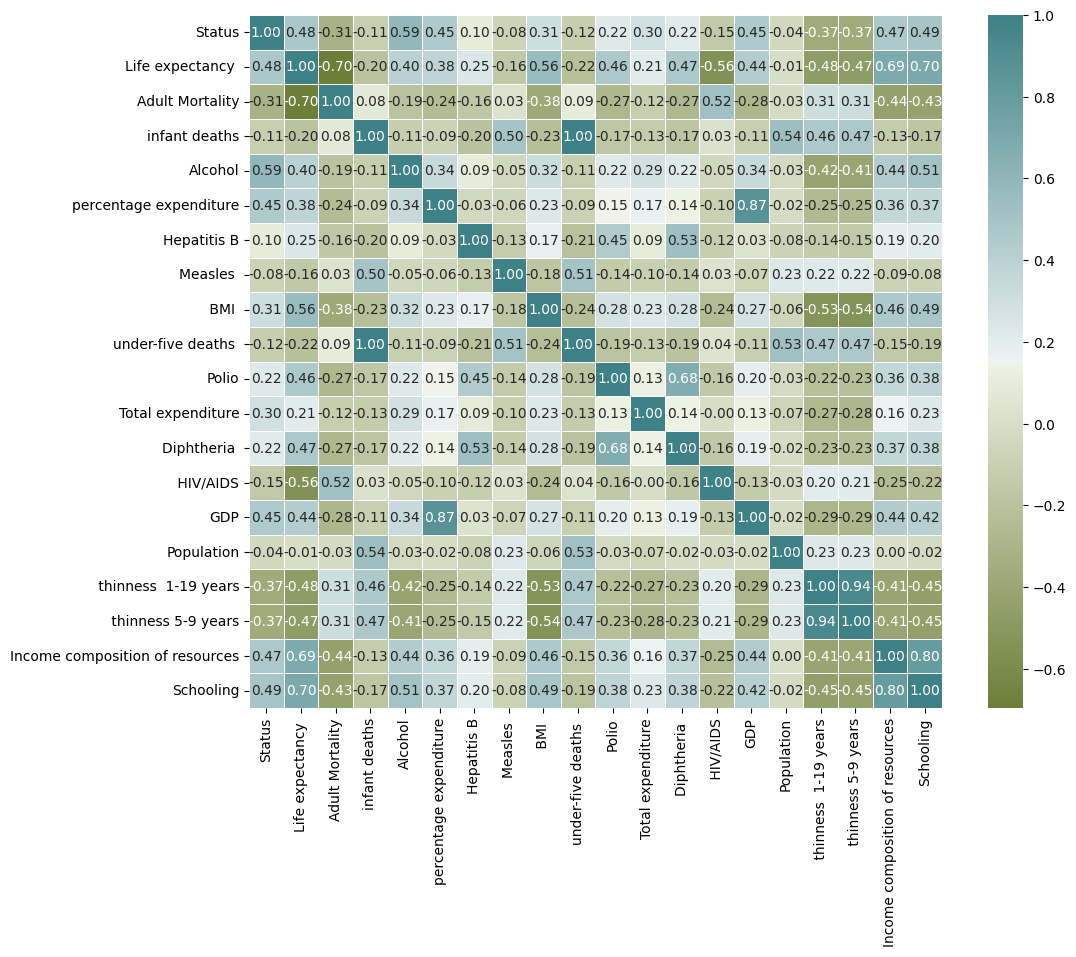

In [ ]:
plt.figure(figsize=(12, 9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

Видна высокая корреляция между Income composition ... & Schooling, thinness 1-19 & thinness 5-9, infant deaths & under-five deaths, поэтому дропаем по признаку из этих пар

In [259]:
data.drop(['Income composition of resources', ' thinness 5-9 years', 'under-five deaths '], axis=1, inplace=True)

<Axes: >

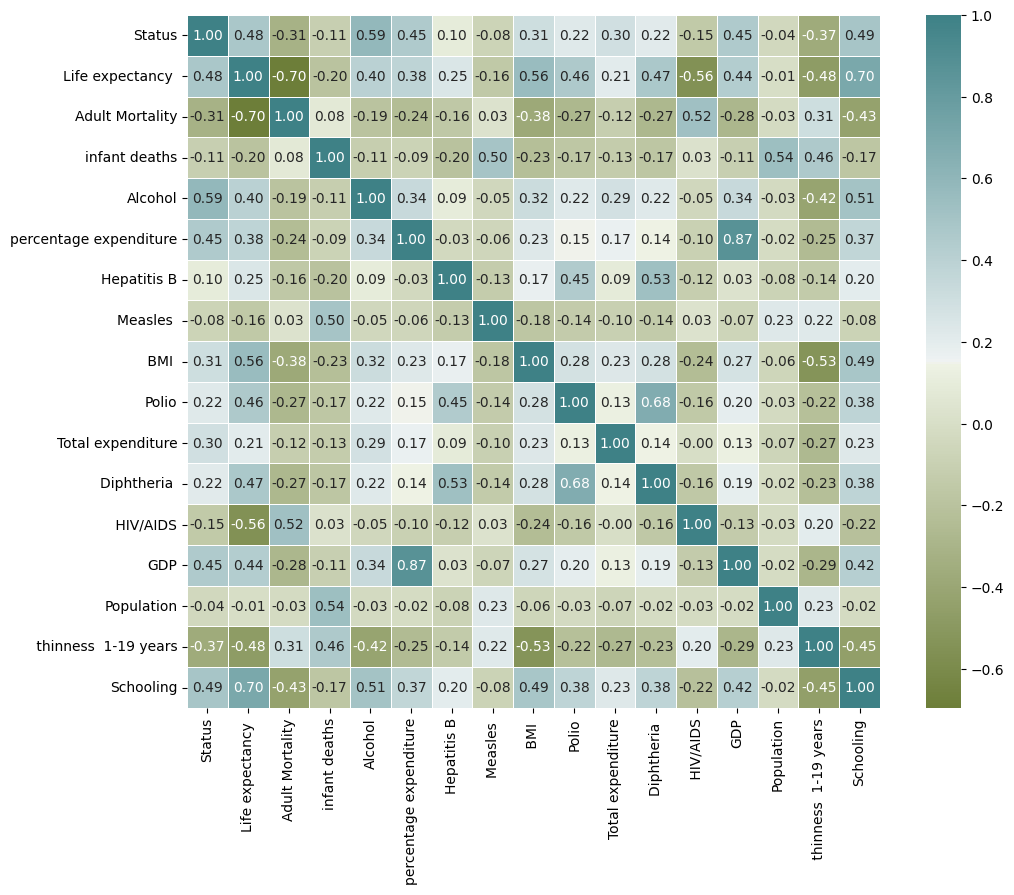

In [221]:
plt.figure(figsize=(12, 9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

In [260]:
data.rename(columns={'Life expectancy ': 'Life expectancy', ' BMI ': 'BMI', ' HIV/AIDS': 'HIV/AIDS', 'Diphtheria ': 'Diphtheria'}, inplace=True)

Долго пришлось скрипеть зубам, чтобы понять, что в названиях столбцов есть какие-то рандомные пробелы, из-за которых у меня постоянно появлялась KeyError :..)

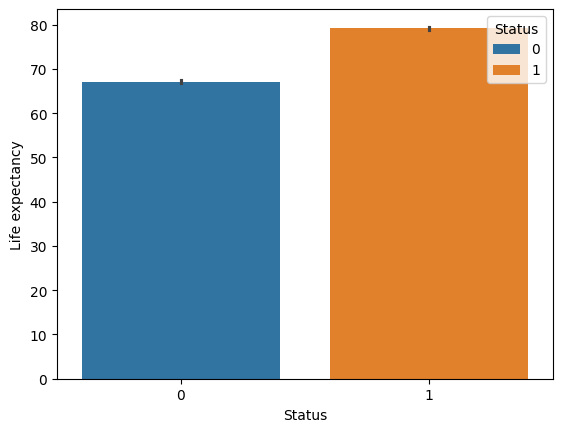

In [ ]:
sns.barplot(y='Life expectancy', x='Status', data=data, hue='Status')
plt.show()

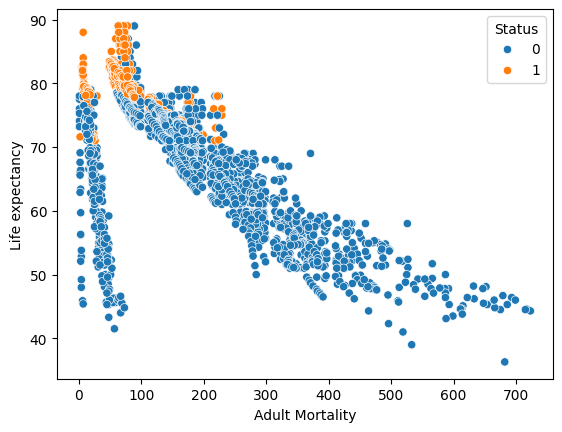

In [ ]:
sns.scatterplot(y='Life expectancy', x='Adult Mortality', data=data, hue='Status')
plt.show()

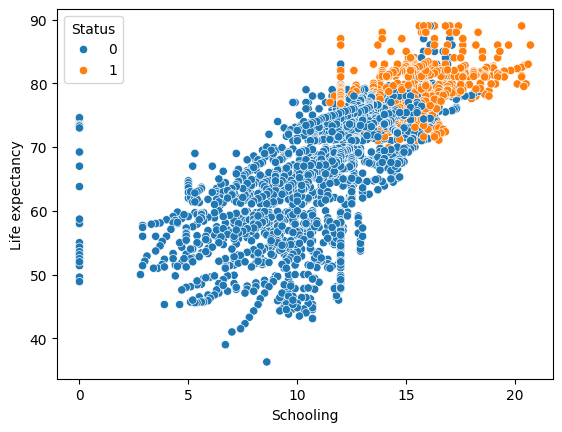

In [ ]:
sns.scatterplot(y='Life expectancy', x='Schooling', data=data, hue='Status')
plt.show()

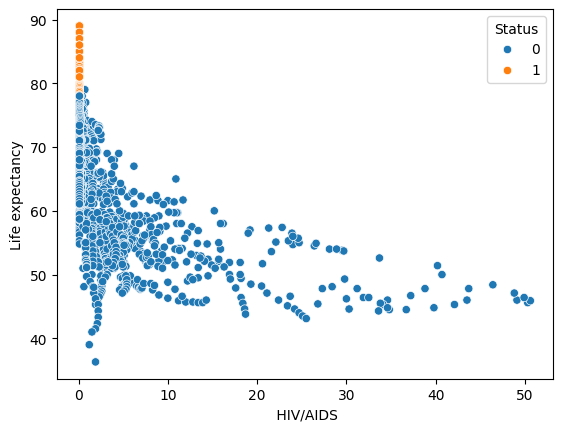

In [ ]:
sns.scatterplot(y='Life expectancy', x='HIV/AIDS', data=data, hue='Status')
plt.show()

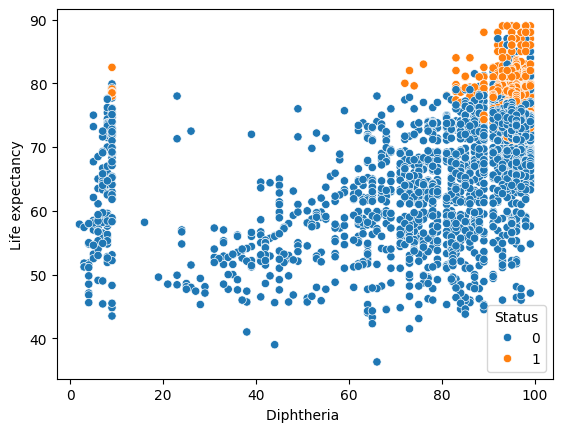

In [ ]:
sns.scatterplot(y='Life expectancy', x='Diphtheria', data=data, hue='Status')
plt.show()

#### Линейная регрессия

In [261]:
X = data.copy().drop('Life expectancy', axis=1)
y = data['Life expectancy']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

model = LinearRegression()
model.fit(Xtrain, ytrain)

ypred_train = model.predict(Xtrain)
ypred_test = model.predict(Xtest)

In [262]:
print(f'MSE на тесте: {mean_squared_error(ypred_test, ytest) ** 0.5}\nMSE на обучении: {mean_squared_error(ypred_train, ytrain) ** 0.5}')

MSE на тесте: 4.006120118184868
MSE на обучении: 4.313133979393503


In [263]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test)

(0.7961577626753276, 0.8156806622585688)

Переобучились... попробуем применить масштабирование:

In [264]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1)
coefficients

,0,0
0,Status,1.850568e+00
1,Adult Mortality,-2.114784e-02
2,infant deaths,-1.117887e-03
3,Alcohol,3.225723e-02
4,percentage expenditure,1.081551e-04
5,Hepatitis B,-1.338684e-02
6,Measles,-4.304179e-05
7,BMI,5.317740e-02
8,Polio,3.117336e-02
9,Total expenditure,7.823728e-03


In [265]:
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)

In [266]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test)

(0.7961577626753276, 0.8156806622589587)

In [267]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(regressor.coef_))], axis=1)
coefficients # ничего не поменялось, но зато коэффициенты стали приятнее

,0,0
0,Status,0.706337
1,Adult Mortality,-2.650616
2,infant deaths,-0.139168
3,Alcohol,0.128765
4,percentage expenditure,0.209531
5,Hepatitis B,-0.331865
6,Measles,-0.520829
7,BMI,1.061024
8,Polio,0.722798
9,Total expenditure,0.019057


Попробуем еще что-нибудь выкинуть:

In [251]:
data.drop(['Measles ', ' thinness  1-19 years', 'Total expenditure'], axis=1, inplace=True)

In [271]:
X = data.copy().drop('Life expectancy', axis=1)
y = data['Life expectancy']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)

In [272]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(regressor.coef_))], axis=1)
coefficients

,0,0
0,Status,0.755029
1,Adult Mortality,-2.629922
2,infant deaths,-0.531675
3,Alcohol,0.167489
4,percentage expenditure,0.215588
5,Hepatitis B,-0.337716
6,BMI,1.211164
7,Polio,0.725939
8,Diphtheria,1.324151
9,HIV/AIDS,-2.438648


In [273]:
r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test)

(0.7934294213136295, 0.8148428154386059)

Уменьшилось совсем чуть-чуть.... попробуем применить регуляризацию

#### L1-регуляризация

In [274]:
regressor2 = Lasso(alpha=0.1)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('Scores:', r2_score(ytest, ypred2), mean_squared_error(ytest, ypred2))
print(regressor2.coef_,'\n')

Scores: 0.8152568387626047 16.08590143435789
[ 0.72591681 -2.61813556 -0.3104572   0.12494503  0.20031251 -0.09459609
  1.19556275  0.65630104  1.20354091 -2.36273517  0.49984385  0.09644147
  2.94555058] 



In [275]:
for a in np.arange(0.01, 0.1, 0.01):
    regressor2 = Lasso(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest, ypred2), mean_squared_error(ytest, ypred2))
    print(regressor2.coef_,'\n')

alpha=0.01
Scores: 0.8149888705170171 16.109233885514342
[ 0.7520991  -2.62861355 -0.50951693  0.16312542  0.21470651 -0.31343532
  1.20964447  0.71895745  1.31216989 -2.43113811  0.50725608  0.2826193
  2.92253691] 

alpha=0.02
Scores: 0.8151113535273248 16.098569081372222
[ 0.74923724 -2.62744571 -0.48740844  0.15885245  0.21309862 -0.28912358
  1.20805756  0.71195839  1.30011017 -2.42353516  0.50641623  0.26193765
  2.92511873] 

alpha=0.03
Scores: 0.8152106916696593 16.089919540271143
[ 0.74632042 -2.62623295 -0.46527229  0.15457651  0.21158246 -0.26483172
  1.20649458  0.70498893  1.28806868 -2.41596072  0.5055278   0.24123956
  2.92770661] 

alpha=0.04
Scores: 0.8152867211937764 16.083299520223537
[ 0.74347139 -2.62508109 -0.4431684   0.15031387  0.20981593 -0.24052246
  1.20489111  0.69798342  1.27600017 -2.40834457  0.50481929  0.22055927
  2.9302904 ] 

alpha=0.05
Scores: 0.8153395131026572 16.078702838879025
[ 0.74019535 -2.62396528 -0.42099624  0.14631115  0.20860132 -0.2161

In [276]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

lasso_cv = LassoCV(alphas=alphas,
                   cv=4, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        8.30854271,  8.35829146,  8.4080402 ,  8.45778894,  8.50753769,
        8.55728643,  8.60703518,  8.65678392,  8.70653266,  8.75628141,
        8.80603015,  8.85577889,  8.90552764,  8.95527638,  9.00502513,
        9.05477387,  9.10452261,  9.15427136,  9.2040201 ,  9.25376884,
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        cv=4, random_state=17)

In [ ]:
lasso_cv.coef_

array([ 0.00000000e+00, -2.28574765e-02, -1.72188124e-03,  8.03573108e-02,
        2.05711160e-04, -8.43992081e-03, -4.33268020e-05,  5.82659142e-02,
        3.04357930e-02,  0.00000000e+00,  4.98987892e-02, -4.52419185e-01,
        4.50969361e-05,  4.59782402e-09, -4.40261961e-02,  8.38393249e-01])

In [277]:
lasso_cv.alpha_

0.1

In [278]:
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred2_train), r2_score(ytest, ypred2_test)) # стало больше...

Scores: 0.7922956064462265 0.8152568387626047


#### L2-регуляризация

In [279]:
from sklearn.linear_model import Ridge

for a in np.arange(0.1, 10.1, 2.5):
    regressor3 = Ridge(alpha=a)
    regressor3.fit(Xtrain, ytrain)

    ypred3 = regressor3.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:',r2_score(ytest, ypred3), mean_squared_error(ytest, ypred3))
    print(regressor3.coef_)

alpha=0.1
Scores: 0.814842950884997 16.12193935619207
[ 0.7550348  -2.62986907 -0.53164453  0.16754435  0.21563157 -0.33764099
  1.21119095  0.72597451  1.32408684 -2.43858732  0.50869078  0.30330602
  2.91976206]
alpha=2.6
Scores: 0.814846041594761 16.12167024283332
[ 0.75517647 -2.62854037 -0.53087528  0.16893606  0.2167079  -0.3357605
  1.21186375  0.72685627  1.32249466 -2.43707285  0.50880749  0.30279044
  2.915969  ]
alpha=5.1
Scores: 0.8148485681690782 16.121450249707948
[ 0.75531823 -2.62721188 -0.53011002  0.1703199   0.21777474 -0.33388885
  1.21252996  0.72772984  1.3209131  -2.4355607   0.5089287   0.30227698
  2.91219248]
alpha=7.6
Scores: 0.8148505364783385 16.1212788656711
[ 0.75546006 -2.6258836  -0.52934872  0.17169595  0.21883225 -0.33202596
  1.21318963  0.72859532  1.31934203 -2.43405086  0.50905426  0.30176562
  2.90843239]


In [280]:
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.66778e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.61608e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.66779e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.61609e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_mean_squared_error')

In [281]:
ridge_cv.alpha_

3217.641750250735

In [282]:
regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test)) # получился какой-то кошмар

Scores: 0.0 -8.85423590151202e-05


#### ElasticNet

In [283]:
from sklearn.linear_model import ElasticNet

regressor3 = ElasticNet(alpha=0.1, l1_ratio=0.5)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain, ypred3_train), r2_score(ytest, ypred3_test))

Scores: 0.7924173431415386 0.8145784634754578


In [284]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(regressor3.coef_))], axis=1)
coefficients

,0,0
0,Status,0.747774
1,Adult Mortality,-2.560979
2,infant deaths,-0.401052
3,Alcohol,0.205233
4,percentage expenditure,0.250055
5,Hepatitis B,-0.147452
6,BMI,1.227704
7,Polio,0.726641
8,Diphtheria,1.205764
9,HIV/AIDS,-2.334650
